### Import dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## Import from local directory
import sys
sys.path.insert(0, './fnn')

from chaos_models import *
from utils import *
from models import *

print(tf.__version__) # 2.0 or greater

%matplotlib inline
%load_ext autoreload
%autoreload 2

2.2.0


# Lorenz attractor

### Simulate the Lorenz system

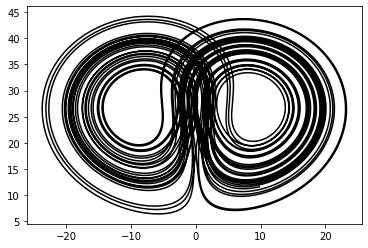

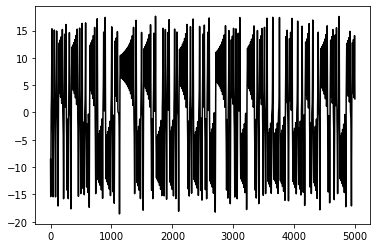

In [2]:
eq = Lorenz()
tpts = np.linspace(0, 500, 125000)
sol = eq.integrate((-8.60632853, -14.85273055,  15.53352487), tpts)
obs = sol[0][::10]

plt.figure()
plt.plot(sol[1][:10000], sol[2][:10000], 'k')


plt.figure()
plt.plot(obs[:5000], 'k')

### Initialize dataset

In [3]:
TIME_WINDOW = 10
SAMPLE_WINDOW = 5000
TRAIN_TEST_SPLIT = 0.5
MAX_EMBEDDING = 10  # the maximum embedding dimension used by network


# train with start of time series, test with end of time series 
X_train = hankel_matrix(obs[:(SAMPLE_WINDOW+MAX_EMBEDDING)], SAMPLE_WINDOW, q=TIME_WINDOW) ## (samples, lookback, features)
X_test = hankel_matrix(obs[-(SAMPLE_WINDOW+MAX_EMBEDDING):], SAMPLE_WINDOW, q=TIME_WINDOW) 

# standardize train and test separately
X_train = (X_train - np.mean(X_train, 0))/np.std(X_train, 0)
X_test = (X_test - np.mean(X_test, 0))/np.std(X_test, 0)

#### Initialize and train model
We use the function`train_autoencoder`, which wraps several standard boilerplate steps in keras: initializing an autoencoder model, compiling it, and then training it. To use the false-neighbors loss with a custom keras model, use the function `loss_false`

In [8]:
from models import *

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


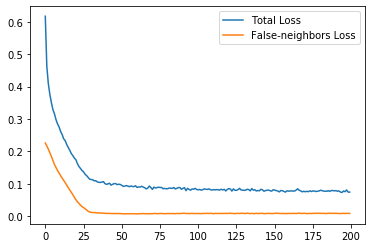

In [4]:
# LSTM params
TRAIN_STEPS = 200
LAMBDA_LATENT = 3e-2
LEARNING_RATE= 1e-3
BATCH_SIZE = 100

tf.random.set_seed(0), np.random.seed(0)

enc, dec, train_history = train_autoencoder(X_train, 
                             network_type='lstm',
                             return_history=True,
                             batch_size=BATCH_SIZE, train_time=TRAIN_STEPS,
                             lambda_latent=LAMBDA_LATENT, learning_rate=LEARNING_RATE)

plt.plot(train_history.history['loss'])
plt.plot(np.array(train_history.history['loss']) - np.array(train_history.history['mse_loss']))
plt.legend(["Total Loss", "False-neighbors Loss"])


#### Embed test data and view the embedding

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


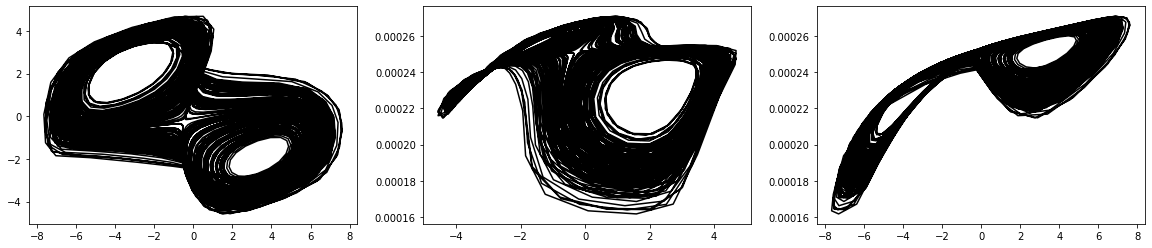

In [5]:
%matplotlib inline

coords_nn = enc.predict(X_test)[TIME_WINDOW:]

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,4))
ax[0].plot(coords_nn[:,0], coords_nn[:,1], 'k')
ax[1].plot(coords_nn[:,1], coords_nn[:,2], 'k')
ax[2].plot(coords_nn[:,0], coords_nn[:,2], 'k')

In [14]:
# View interactive plot in 3D. Requires mplot3d to be working on your system

%matplotlib widget
%matplotlib widget
%matplotlib widget
%matplotlib widget

from mpl_toolkits.mplot3d import axes3d
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection= '3d')
ax.plot(coords_nn[:,0], coords_nn[:,1], coords_nn[:,2], color='k')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…

# Double pendulum dataset

Experimental dataset from [Asseman et al 2019](https://developer.ibm.com/exchanges/data/all/double-pendulum-chaotic/) corresponding to centroid measurements of a chaotic double pendulum. $\dot\theta_1$ (the angular velocity of the second coordinate) is extracted and used for fitting the model

#### Import dataset

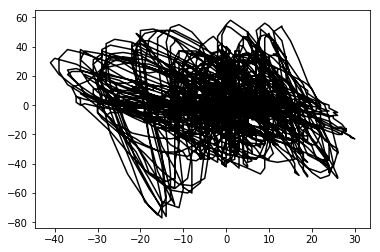

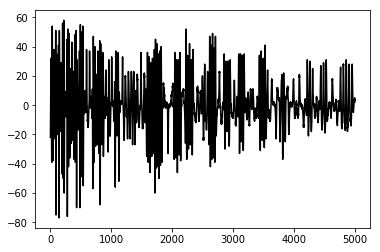

In [6]:

# from load_datasets import import_pendulum

sol = np.load('datasets/pendulum_train.pkl', allow_pickle=True)
sol_test = np.load('datasets/pendulum_test.pkl', allow_pickle=True)
obs, obs_test = sol[3], sol_test[3]

%matplotlib inline

plt.figure()
plt.plot(sol[2, :], sol[3, :], 'k')

plt.figure()
plt.plot(obs[:5000], 'k')

#### Prepare train and test datasets

In [22]:
TIME_WINDOW = 10
SAMPLE_WINDOW = 5000
TRAIN_TEST_SPLIT = 0.5
MAX_EMBEDDING = 10  # the maximum embedding dimension used by network

# train and test with separate experiments
X_train = hankel_matrix(obs[:(SAMPLE_WINDOW+MAX_EMBEDDING)], SAMPLE_WINDOW, q=TIME_WINDOW)  ## (samples, lookback, features)
X_test = hankel_matrix(obs_test[-(SAMPLE_WINDOW+MAX_EMBEDDING):], SAMPLE_WINDOW, q=TIME_WINDOW) 

# standardize train and test separately
X_train = (X_train - np.mean(X_train, 0))/np.std(X_train, 0)
X_test = (X_test - np.mean(X_test, 0))/np.std(X_test, 0)

### Initialize model

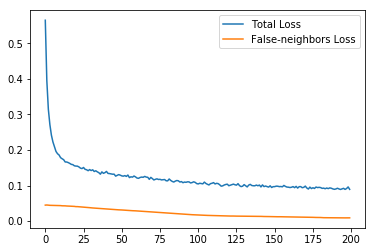

In [23]:
# LSTM params
TRAIN_STEPS = 200
LAMBDA_LATENT = 0.006 
LEARNING_RATE = 0.001
BATCH_SIZE = 100

tf.random.set_seed(0), np.random.seed(0)

enc, dec = enc_dec_lstm(TIME_WINDOW, 1, MAX_EMBEDDING, rnn_opts={'activation': None, 'batch_size': BATCH_SIZE})
enc, dec, train_history = train_autoencoder(X_train, 
                             network_type='lstm',
                             return_history=True,
                             batch_size=BATCH_SIZE, train_time=TRAIN_STEPS,
                             lambda_latent=LAMBDA_LATENT, learning_rate=LEARNING_RATE)

plt.plot(train_history.history['loss'])
plt.plot(np.array(train_history.history['loss']) - np.array(train_history.history['mse_loss']))
plt.legend(["Total Loss", "False-neighbors Loss"])

### Embed test data and visualize embeddings

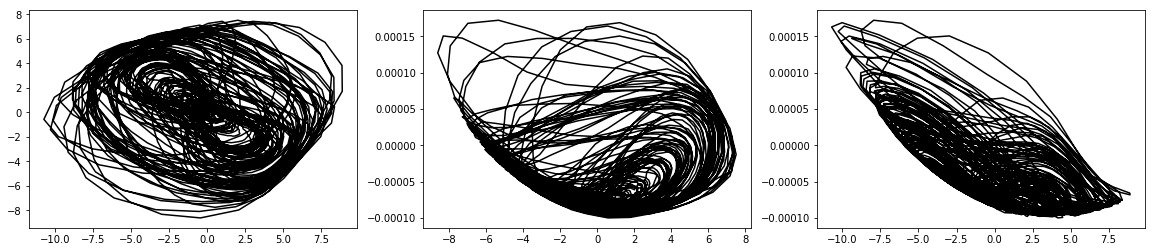

In [11]:
%matplotlib inline

coords_nn = enc.predict(X_test)[TIME_WINDOW:]

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,4))
ax[0].plot(coords_nn[:,0], coords_nn[:,1], 'k')
ax[1].plot(coords_nn[:,1], coords_nn[:,2], 'k')
ax[2].plot(coords_nn[:,0], coords_nn[:,2], 'k')

In [23]:
# View interactive plot in 3D. Requires mplot3d to be working on your system

%matplotlib widget
%matplotlib widget
%matplotlib widget
%matplotlib widget

from mpl_toolkits.mplot3d import axes3d
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection= '3d')
ax.plot(coords_nn[:,0], coords_nn[:,1], coords_nn[:,2], color='k')
ax.set_aspect('equal')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…

# Torus dataset

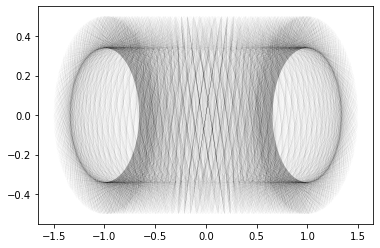

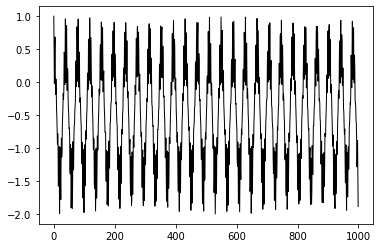

In [6]:
tor = Torus2(r=1, a=.5, n=10.3)
tpts = np.linspace(0, 2000, 100000)
sol = tor.integrate((1, 0, 0), tpts)
sol = sol[:, ::8]
obs = sol[0]

plt.figure()
plt.plot(sol[1][:10000], sol[2][:10000], 'k', linewidth=.01)

plt.figure()
plt.plot(obs[:1000], 'k', linewidth=1)

In [8]:
TIME_WINDOW = 10
SAMPLE_WINDOW = 5000
TRAIN_TEST_SPLIT = 0.5
MAX_EMBEDDING = 10  # the maximum embedding dimension used by network

# train and test with separate experiments
X_train = hankel_matrix(obs[:(SAMPLE_WINDOW+MAX_EMBEDDING)], SAMPLE_WINDOW, q=TIME_WINDOW)  ## (samples, lookback, features)
X_test = hankel_matrix(obs[-(SAMPLE_WINDOW+MAX_EMBEDDING):], SAMPLE_WINDOW, q=TIME_WINDOW) 

# standardize train and test separately
X_train = (X_train - np.mean(X_train, 0))/np.std(X_train, 0)
X_test = (X_test - np.mean(X_test, 0))/np.std(X_test, 0)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity 

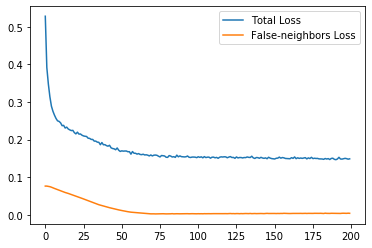

<Figure size 432x288 with 0 Axes>

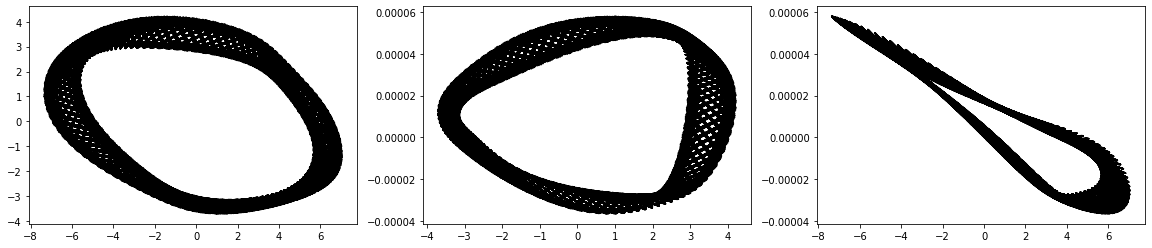

In [9]:
# Train model
TRAIN_STEPS = 200
LAMBDA_LATENT = 1e-2
LEARNING_RATE = 1e-3
BATCH_SIZE = 100

tf.random.set_seed(0), np.random.seed(0)

enc, dec = enc_dec_lstm(TIME_WINDOW, 1, MAX_EMBEDDING, rnn_opts={'activation': None, 'batch_size': BATCH_SIZE})
enc, dec, train_history = train_autoencoder(X_train, 
                             network_type='lstm',
                             return_history=True,
                             batch_size=BATCH_SIZE, train_time=TRAIN_STEPS,
                             lambda_latent=LAMBDA_LATENT, learning_rate=LEARNING_RATE)

%matplotlib inline
coords_nn = enc.predict(X_test)[TIME_WINDOW:]
plt.figure()
plt.plot(train_history.history['loss'])
plt.plot(np.array(train_history.history['loss']) - np.array(train_history.history['mse_loss']))
plt.legend(["Total Loss", "False-neighbors Loss"])


coords_nn = enc.predict(X_test)[TIME_WINDOW:]
plt.figure()
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,4))
ax[0].plot(coords_nn[:,0], coords_nn[:,1], 'k')
ax[1].plot(coords_nn[:,1], coords_nn[:,2], 'k')
ax[2].plot(coords_nn[:,0], coords_nn[:,2], 'k')

# Rössler

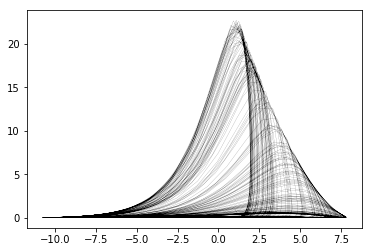

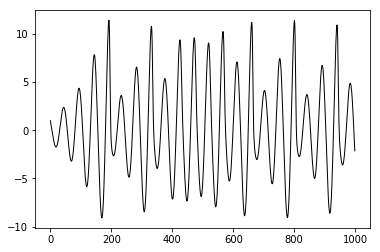

In [38]:
ross = Rossler(.2, .2, 5.7)
tpts = np.linspace(0, 2500, 20000)
sol = ross.integrate((1, 1, 1.05), tpts)
obs = sol[0]

plt.figure()
plt.plot(sol[1][:10000], sol[2][:10000], 'k', linewidth=.1)

plt.figure()
plt.plot(obs[:1000], 'k', linewidth=1)

In [39]:
TIME_WINDOW = 10
SAMPLE_WINDOW = 5000
TRAIN_TEST_SPLIT = 0.5
MAX_EMBEDDING = 10  # the maximum embedding dimension used by network

# train and test with separate experiments
X_train = hankel_matrix(obs[:(SAMPLE_WINDOW+MAX_EMBEDDING)], SAMPLE_WINDOW, q=TIME_WINDOW) 
X_test = hankel_matrix(obs[-(SAMPLE_WINDOW+MAX_EMBEDDING):], SAMPLE_WINDOW, q=TIME_WINDOW) 

# standardize train and test separately
X_train = (X_train - np.mean(X_train, 0))/np.std(X_train, 0)
X_test = (X_test - np.mean(X_test, 0))/np.std(X_test, 0)

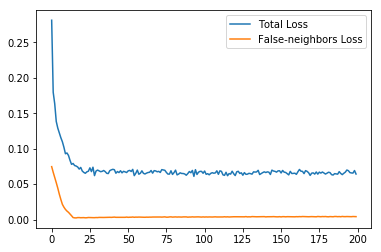

<Figure size 432x288 with 0 Axes>

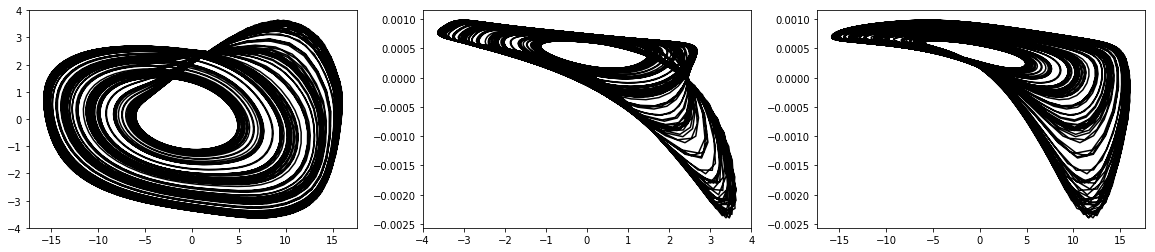

In [40]:
# Train model
TRAIN_STEPS = 200
LAMBDA_LATENT = 1e-2
LEARNING_RATE = 1e-2
BATCH_SIZE = 100

tf.random.set_seed(0), np.random.seed(0)

enc, dec = enc_dec_lstm(TIME_WINDOW, 1, MAX_EMBEDDING, rnn_opts={'activation': None, 'batch_size': BATCH_SIZE})
enc, dec, train_history = train_autoencoder(X_train, 
                             network_type='lstm',
                             return_history=True,
                             batch_size=BATCH_SIZE, train_time=TRAIN_STEPS,
                             lambda_latent=LAMBDA_LATENT, learning_rate=LEARNING_RATE)

%matplotlib inline
coords_nn = enc.predict(X_test)[TIME_WINDOW:]
plt.figure()
plt.plot(train_history.history['loss'])
plt.plot(np.array(train_history.history['loss']) - np.array(train_history.history['mse_loss']))
plt.legend(["Total Loss", "False-neighbors Loss"])


coords_nn = enc.predict(X_test)[TIME_WINDOW:]
plt.figure()
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,4))
ax[0].plot(coords_nn[:,0], coords_nn[:,1], 'k')
ax[1].plot(coords_nn[:,1], coords_nn[:,2], 'k')
ax[2].plot(coords_nn[:,0], coords_nn[:,2], 'k')

# Ecosystem model

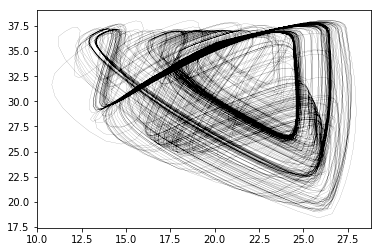

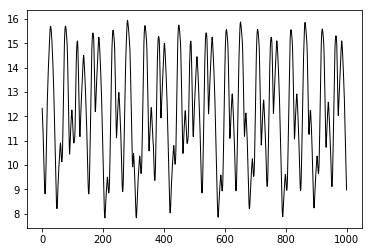

In [41]:
ma = MacArthur()

tpts = np.linspace(0, 20000, 200000)
sol = ma.integrate(None, tpts)[:, 10000::10] # remove transient 
obs = sol[0]

plt.figure()
plt.plot(sol[1][:10000], sol[2][:10000], 'k', linewidth=.1)

plt.figure()
plt.plot(obs[:1000], 'k', linewidth=1)

In [42]:
TIME_WINDOW = 10
SAMPLE_WINDOW = 5000
TRAIN_TEST_SPLIT = 0.5
MAX_EMBEDDING = 10  # the maximum embedding dimension used by network

# train and test with separate experiments
X_train = hankel_matrix(obs[:(SAMPLE_WINDOW+MAX_EMBEDDING)], SAMPLE_WINDOW, q=TIME_WINDOW) 
X_test = hankel_matrix(obs[-(SAMPLE_WINDOW+MAX_EMBEDDING):], SAMPLE_WINDOW, q=TIME_WINDOW) 

# standardize train and test separately
X_train = (X_train - np.mean(X_train, 0))/np.std(X_train, 0)
X_test = (X_test - np.mean(X_test, 0))/np.std(X_test, 0)

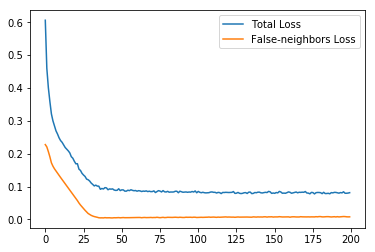

<Figure size 432x288 with 0 Axes>

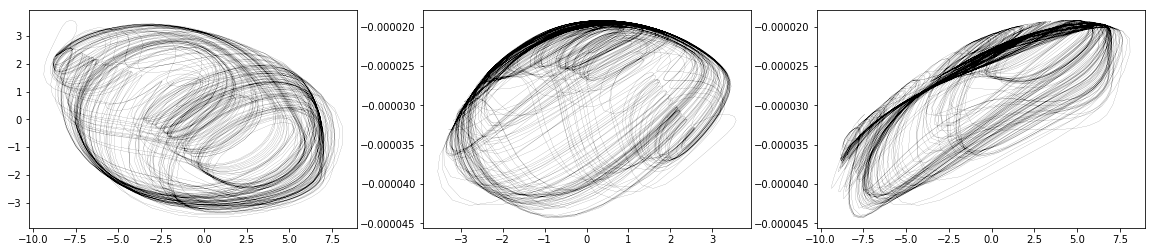

In [44]:
# Train model
TRAIN_STEPS = 200
LAMBDA_LATENT = 3e-2
LEARNING_RATE = 1e-3
BATCH_SIZE = 100

tf.random.set_seed(0), np.random.seed(0)

enc, dec = enc_dec_lstm(TIME_WINDOW, 1, MAX_EMBEDDING, rnn_opts={'activation': None, 'batch_size': BATCH_SIZE})
enc, dec, train_history = train_autoencoder(X_train, 
                             network_type='lstm',
                             return_history=True,
                             batch_size=BATCH_SIZE, train_time=TRAIN_STEPS,
                             lambda_latent=LAMBDA_LATENT, learning_rate=LEARNING_RATE)

%matplotlib inline
coords_nn = enc.predict(X_test)[TIME_WINDOW:]
plt.figure()
plt.plot(train_history.history['loss'])
plt.plot(np.array(train_history.history['loss']) - np.array(train_history.history['mse_loss']))
plt.legend(["Total Loss", "False-neighbors Loss"])


coords_nn = enc.predict(X_test)[TIME_WINDOW:]
plt.figure()
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,4))
ax[0].plot(coords_nn[:,0], coords_nn[:,1], 'k', linewidth=0.1)
ax[1].plot(coords_nn[:,1], coords_nn[:,2], 'k', linewidth=0.1)
ax[2].plot(coords_nn[:,0], coords_nn[:,2], 'k', linewidth=0.1)